In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import lightgbm
import shap
import itertools
pd.options.mode.chained_assignment = None

os.chdir('/Users/stevengeorge/Documents/Github/fpl-analysis/')

from src.data.gw_features import add_gw_features
from src.features.custom_transformers import TimeSeriesFeatures

%matplotlib inline
pd.set_option('display.max_columns', None)
DATA_PATH = 'data/processed/'

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
full_data = pd.read_parquet('fpl_data_all_seasons.parquet')
print(full_data.shape)
full_data.head()

(67206, 64)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,first_name,second_name,team,position,team_name,promoted_side,top_6_last_season
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,10,0,0,0,0.0,454,0.0,0,2016-08-15 20:00:00+01:00,15 Aug 20:00,0,0,0,0,0,4,0,0,0,0,0,0,1,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,20,0,0,0,0.0,979,0.0,0,2016-08-21 16:00:00+01:00,21 Aug 16:00,0,0,0,0,0,2,0,0,0,0,0,0,2,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,29,0,0,0,0.0,1519,0.0,0,2016-08-28 16:00:00+01:00,28 Aug 16:00,0,0,0,0,0,10,0,0,0,0,0,0,3,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,38,0,0,0,0.0,2069,0.0,0,2016-09-10 15:00:00+01:00,10 Sep 15:00,0,0,0,0,0,18,0,0,0,0,0,0,4,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,46,0,0,0,0.0,2650,0.0,0,2016-09-17 15:00:00+01:00,17 Sep 15:00,0,0,0,0,0,19,0,0,0,0,0,0,5,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0


__Create unique ID for each player, position, season combination__

In [3]:
id_df = full_data.groupby(['name', 'position', 'season']).count().reset_index()[['name', 'position', 'season']]
id_df['ID'] = id_df.index + 1
print(id_df.shape)
id_df.head()

(1932, 4)


,name,position,season,ID
0,aaron_cresswell,DEF,2016-17,1
1,aaron_cresswell,DEF,2017-18,2
2,aaron_cresswell,DEF,2018-19,3
3,aaron_lennon,MID,2016-17,4
4,aaron_lennon,MID,2017-18,5


In [4]:
full_data = full_data.merge(id_df, how='left', on=['name', 'position', 'season'])

In [5]:
team_season_data = pd.read_csv('data/external/team_season_data.csv')
team_season_data.head()

,team_name,team,season,promoted_side,top_6_last_season
0,Arsenal,1,2016-17,0,1
1,Bournemouth,2,2016-17,0,0
2,Burnley,3,2016-17,1,0
3,Chelsea,4,2016-17,0,0
4,Crystal Palace,5,2016-17,0,0


In [6]:
full_data.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,first_name,second_name,team,position,team_name,promoted_side,top_6_last_season,ID
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,10,0,0,0,0.0,454,0.0,0,2016-08-15 20:00:00+01:00,15 Aug 20:00,0,0,0,0,0,4,0,0,0,0,0,0,1,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,20,0,0,0,0.0,979,0.0,0,2016-08-21 16:00:00+01:00,21 Aug 16:00,0,0,0,0,0,2,0,0,0,0,0,0,2,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,29,0,0,0,0.0,1519,0.0,0,2016-08-28 16:00:00+01:00,28 Aug 16:00,0,0,0,0,0,10,0,0,0,0,0,0,3,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,38,0,0,0,0.0,2069,0.0,0,2016-09-10 15:00:00+01:00,10 Sep 15:00,0,0,0,0,0,18,0,0,0,0,0,0,4,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,46,0,0,0,0.0,2650,0.0,0,2016-09-17 15:00:00+01:00,17 Sep 15:00,0,0,0,0,0,19,0,0,0,0,0,0,5,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1


In [7]:
full_data = full_data.merge(
    team_season_data,
    left_on=['opponent_team', 'season'],
    right_on=['team', 'season'],
    suffixes=('', '_opponent'),
    how='left'
)

In [8]:
season_2018_19 = full_data[full_data['season'] == '2018-19'].reset_index(drop=True)
season_2018_19.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,first_name,second_name,team,position,team_name,promoted_side,top_6_last_season,ID,team_name_opponent,team_opponent,promoted_side_opponent,top_6_last_season_opponent
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,402,0,0,5,0,0,0,0.0,402,0.0,0,2018-08-12 13:30:00+01:00,12 Aug 13:30,0,0,0,0,0,12,0,0,0,0,0,0,1,0,103396,0,0,0,0,4,0.0,0,0,0,0,5.5,False,0,0,1,2018-19,aaron,cresswell,19,DEF,West Ham United,0,0,3,Liverpool,12,0,1
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,402,0,0,20,0,0,0,0.0,927,0.0,0,2018-08-18 15:00:00+01:00,18 Aug 15:00,0,0,0,0,0,2,0,0,0,0,0,0,2,0,91333,0,0,0,2,1,0.0,0,-14496,933,15429,5.5,True,0,0,2,2018-19,aaron,cresswell,19,DEF,West Ham United,0,0,3,Bournemouth,2,0,0
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,402,0,0,21,0,0,0,0.0,1454,0.0,0,2018-08-25 15:00:00+01:00,25 Aug 15:00,0,0,0,0,0,1,0,0,0,0,0,0,3,0,69306,0,0,0,1,3,0.0,0,-22473,246,22719,5.4,False,0,0,3,2018-19,aaron,cresswell,19,DEF,West Ham United,0,0,3,Arsenal,1,0,1
3,aaron_cresswell,0,47,0,0,0,10,0,1,39,27.6,0,0,402,0,0,40,1,1,0,3.7,1985,9.8,2,2018-09-01 15:00:00+01:00,01 Sep 15:00,0,0,90,0,1,20,0,0,0,0,4,0,4,0,57685,0,0,0,1,0,0.0,1,-12459,275,12734,5.3,True,0,1,4,2018-19,aaron,cresswell,19,DEF,West Ham United,0,0,3,Wolverhampton Wanderers,20,1,0
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,402,0,0,43,0,0,0,0.0,2522,0.0,0,2018-09-16 16:00:00+01:00,16 Sep 16:00,0,0,0,0,0,8,0,0,0,0,0,0,5,0,51987,0,0,0,3,1,0.0,0,-6122,245,6367,5.3,False,0,0,5,2018-19,aaron,cresswell,19,DEF,West Ham United,0,0,3,Everton,8,0,0


In [9]:
season_2016_17 = full_data[full_data['season'] == '2016-17'].reset_index(drop=True)
season_2016_17.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,first_name,second_name,team,position,team_name,promoted_side,top_6_last_season,ID,team_name_opponent,team_opponent,promoted_side_opponent,top_6_last_season_opponent
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,10,0,0,0,0.0,454,0.0,0,2016-08-15 20:00:00+01:00,15 Aug 20:00,0,0,0,0,0,4,0,0,0,0,0,0,1,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1,Chelsea,4,0,0
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,20,0,0,0,0.0,979,0.0,0,2016-08-21 16:00:00+01:00,21 Aug 16:00,0,0,0,0,0,2,0,0,0,0,0,0,2,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1,Bournemouth,2,0,0
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,29,0,0,0,0.0,1519,0.0,0,2016-08-28 16:00:00+01:00,28 Aug 16:00,0,0,0,0,0,10,0,0,0,0,0,0,3,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1,Manchester City,10,0,1
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,38,0,0,0,0.0,2069,0.0,0,2016-09-10 15:00:00+01:00,10 Sep 15:00,0,0,0,0,0,18,0,0,0,0,0,0,4,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1,Watford,18,0,0
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,46,0,0,0,0.0,2650,0.0,0,2016-09-17 15:00:00+01:00,17 Sep 15:00,0,0,0,0,0,19,0,0,0,0,0,0,5,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,aaron,cresswell,20,DEF,West Ham United,0,0,1,West Bromwich Albion,19,0,0


In [10]:
season_2016_17 = pd.get_dummies(season_2016_17, columns=['position'])

In [11]:
static_features = [
    'position_DEF', 'position_FWD', 'position_GK', 'position_MID', 'was_home', 'promoted_side', 'top_6_last_season',
    'promoted_side_opponent', 'top_6_last_season_opponent', 'gw', 'value'
]

In [12]:
training_data = season_2016_17.copy()[static_features + ['total_points']]
training_data.head()

,position_DEF,position_FWD,position_GK,position_MID,was_home,promoted_side,top_6_last_season,promoted_side_opponent,top_6_last_season_opponent,gw,value,total_points
0,1,0,0,0,False,0,0,0,0,1,5.5,0
1,1,0,0,0,True,0,0,0,0,2,5.5,0
2,1,0,0,0,False,0,0,0,1,3,5.4,0
3,1,0,0,0,True,0,0,0,0,4,5.4,0
4,1,0,0,0,False,0,0,0,0,5,5.4,0


In [13]:
lgbm_model = lightgbm.LGBMRegressor()

In [14]:
lgbm_model.fit(
    training_data.drop('total_points', axis=1),
    training_data['total_points']
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [15]:
predictions = lgbm_model.predict(training_data.drop('total_points', axis=1))

In [16]:
mean_squared_error(training_data['total_points'], predictions)

4.502337527362055

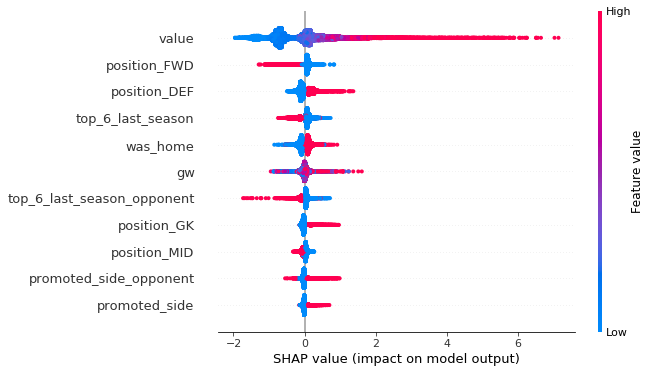

In [17]:
# LightGBM shap
shap_values = shap.TreeExplainer(lgbm_model).shap_values(training_data.drop('total_points', axis=1))

shap.summary_plot(
    shap_values,
    training_data.drop('total_points', axis=1)
)

In [18]:
season_2017_18 = full_data[full_data['season'] == '2017-18'].reset_index(drop=True)
season_2017_18 = pd.get_dummies(season_2017_18, columns=['position'])
season_2017_18.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,first_name,second_name,team,team_name,promoted_side,top_6_last_season,ID,team_name_opponent,team_opponent,promoted_side_opponent,top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID
0,aaron_cresswell,0,10,0,0,0,3,0,0,9,0.6,0,0,443,0,0,9,0,2,0,1.9,443,0.4,0,2017-08-13 16:00:00+01:00,13 Aug 16:00,0,0,9,0,0,12,0,0,0,0,0,0,1,0,25136,0,0,0,0,4,18.0,0,0,0,0,5.0,False,0,0,1,2017-18,aaron,cresswell,20,West Ham United,0,0,2,Manchester United,12,0,1,1,0,0,0
1,aaron_cresswell,0,21,0,0,0,16,0,6,17,52.9,0,0,443,0,0,15,0,3,0,7.4,954,21.2,4,2017-08-19 15:00:00+01:00,19 Aug 15:00,0,0,90,0,3,14,0,0,0,0,2,0,2,0,27824,0,0,0,2,3,0.0,1,-1515,945,2460,5.0,False,0,0,2,2017-18,aaron,cresswell,20,West Ham United,0,0,2,Southampton,14,0,0,1,0,0,0
2,aaron_cresswell,0,43,0,0,0,11,0,4,36,1.6,0,0,443,0,0,26,1,3,0,2.4,1470,11.2,0,2017-08-26 15:00:00+01:00,26 Aug 15:00,0,0,90,0,0,13,0,0,0,0,3,0,3,0,28464,0,0,1,0,3,11.0,1,-269,2323,2592,5.0,False,0,0,3,2017-18,aaron,cresswell,20,West Ham United,0,0,2,Newcastle United,13,1,0,1,0,0,0
3,aaron_cresswell,0,22,1,0,0,23,1,3,14,47.1,0,0,443,0,0,40,1,0,0,6.2,2001,14.2,3,2017-09-11 20:00:00+01:00,11 Sep 20:00,0,0,90,0,2,8,0,0,0,0,4,0,4,0,28977,3,0,1,0,2,1.0,6,-338,2793,3131,5.0,True,0,0,4,2017-18,aaron,cresswell,20,West Ham United,0,0,2,Huddersfield Town,8,1,0,1,0,0,0
4,aaron_cresswell,0,30,0,0,3,30,1,4,27,34.3,0,0,443,0,0,48,0,0,0,4.6,2545,11.2,2,2017-09-16 15:00:00+01:00,16 Sep 15:00,0,0,90,0,1,19,0,0,0,0,4,0,5,0,30355,0,0,0,0,0,0.0,9,905,3136,2231,5.0,False,0,0,5,2017-18,aaron,cresswell,20,West Ham United,0,0,2,West Bromwich Albion,19,0,0,1,0,0,0


In [19]:
test_data = season_2017_18.copy()[static_features + ['total_points']]

In [20]:
predictions = lgbm_model.predict(test_data.drop('total_points', axis=1))

In [21]:
mean_squared_error(test_data['total_points'], predictions)

5.788249383375019

In [22]:
last_10_gw_1718 = season_2017_18[season_2017_18['gw']>=29].groupby('name').sum()['total_points'].reset_index()
last_10_gw_1718.head()

,name,total_points
0,aaron_cresswell,34
1,aaron_lennon,26
2,aaron_mooy,19
3,aaron_ramsdale,0
4,aaron_ramsey,24


In [23]:
gw1_value_1819 = season_2018_19[season_2018_19['gw'] == 1][['name', 'team_name', 'position', 'value']]
gw1_value_1819.rename(columns={'value': 'gw1_value_1819'}, inplace=True)

roi_data = gw1_value_1819.merge(last_10_gw_1718, on=['name'])

In [24]:
roi_data['ROI'] = roi_data['total_points'] / roi_data['gw1_value_1819']
roi_data.sort_values('ROI', inplace=True, ascending=False)
roi_data.reset_index(inplace=True, drop=True)
roi_data.head(40)

,name,team_name,position,gw1_value_1819,total_points,ROI
0,patrick_van aanholt,Crystal Palace,DEF,5.5,68,12.363636
1,lukasz_fabianski,West Ham United,GK,4.5,45,10.000000
2,james_tomkins,Crystal Palace,DEF,4.5,42,9.333333
3,mathew_ryan,Brighton & Hove Albion,GK,4.5,42,9.333333
4,wilfried_zaha,Crystal Palace,FWD,7.0,64,9.142857
5,florian_lejeune,Newcastle United,DEF,4.5,41,9.111111
6,loris_karius,Liverpool,GK,5.0,45,9.000000
7,ayoze_perez,Newcastle United,FWD,6.5,58,8.923077
8,jordan_pickford,Everton,GK,5.0,44,8.800000
9,wayne_hennessey,Crystal Palace,GK,4.5,39,8.666667


In [25]:
best_in_season1718 = season_2017_18.groupby(['name']).sum()['total_points'].sort_values(ascending=False).head(3).reset_index()
best_in_season1718.drop('total_points', axis=1, inplace=True)
best_in_season1718['best_in_season1718'] = 1
best_in_season1718

,name,best_in_season1718
0,mohamed_salah,1
1,raheem_sterling,1
2,harry_kane,1


# Select best team

In [26]:
from pulp import *

In [27]:
roi_data.head()

,name,team_name,position,gw1_value_1819,total_points,ROI
0,patrick_van aanholt,Crystal Palace,DEF,5.5,68,12.363636
1,lukasz_fabianski,West Ham United,GK,4.5,45,10.000000
2,james_tomkins,Crystal Palace,DEF,4.5,42,9.333333
3,mathew_ryan,Brighton & Hove Albion,GK,4.5,42,9.333333
4,wilfried_zaha,Crystal Palace,FWD,7.0,64,9.142857


In [28]:
roi_data = roi_data.merge(best_in_season1718, on=['name'], how='left')

In [29]:
roi_data['best_in_season1718'].fillna(0, inplace=True)

In [30]:
roi_data['name'] = roi_data['name'].str.replace(' ', '_')
roi_data['name'] = roi_data['name'].str.replace('-', '_')

In [31]:
roi_data['team_name'] = roi_data['team_name'].str.replace(' ', '_')
roi_data['team_name'] = roi_data['team_name'].str.lower()
team_names = roi_data['team_name'].unique()

In [32]:
team_names

array(['crystal_palace', 'west_ham_united', 'brighton_&_hove_albion',
       'newcastle_united', 'liverpool', 'everton', 'burnley',
       'southampton', 'manchester_united', 'watford', 'huddersfield_town',
       'tottenham_hotspur', 'bournemouth', 'arsenal', 'chelsea',
       'manchester_city', 'leicester_city', 'fulham', 'cardiff_city'],
      dtype=object)

In [33]:
roi_data = pd.get_dummies(roi_data, columns=['position', 'team_name'])
roi_data.head()

,name,gw1_value_1819,total_points,ROI,best_in_season1718,position_DEF,position_FWD,position_GK,position_MID,team_name_arsenal,team_name_bournemouth,team_name_brighton_&_hove_albion,team_name_burnley,team_name_cardiff_city,team_name_chelsea,team_name_crystal_palace,team_name_everton,team_name_fulham,team_name_huddersfield_town,team_name_leicester_city,team_name_liverpool,team_name_manchester_city,team_name_manchester_united,team_name_newcastle_united,team_name_southampton,team_name_tottenham_hotspur,team_name_watford,team_name_west_ham_united
0,patrick_van_aanholt,5.5,68,12.363636,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,lukasz_fabianski,4.5,45,10.000000,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,james_tomkins,4.5,42,9.333333,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,mathew_ryan,4.5,42,9.333333,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,wilfried_zaha,7.0,64,9.142857,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
players = list(roi_data['name'])

In [35]:
team_dict = {}

for team in team_names:
    team_dict[team] = dict(
        zip(
            roi_data['name'],
            roi_data[f'team_name_{team}']
        )
    
    )

In [37]:
costs = dict(
    zip(
        roi_data['name'],
        roi_data['gw1_value_1819']
    )
)

In [38]:
DEF_flag = dict(
    zip(
        roi_data['name'],
        roi_data['position_DEF']
    )
)

FWD_flag = dict(
    zip(
        roi_data['name'],
        roi_data['position_FWD']
    )
)

GK_flag = dict(
    zip(
        roi_data['name'],
        roi_data['position_GK']
    )
)

MID_flag = dict(
    zip(
        roi_data['name'],
        roi_data['position_MID']
    )
)

In [39]:
roi = dict(
    zip(
        roi_data['name'],
        roi_data['ROI']
    )
)

In [41]:
best_in_prev_season = dict(
    zip(
        roi_data['name'],
        roi_data['best_in_season1718']
    )
)

In [42]:
prob = LpProblem('FPL team selection', LpMaximize)

In [43]:
player_vars = LpVariable.dicts('player', players, 0, 1, LpInteger)

In [44]:
# Objective function:
prob += lpSum([roi[p] * player_vars[p] for p in players]), "Total cost of team"

In [45]:
# Constraints
prob += lpSum([costs[p] * player_vars[p] for p in players]) <= 100, "Total cost less than £100m"

prob += lpSum(player_vars[p] for p in players) == 15, "Select 15 players"

prob += lpSum(DEF_flag[p] * player_vars[p] for p in players) == 5, "5 defenders"

prob += lpSum(GK_flag[p] * player_vars[p] for p in players) == 2, "2 goalkeepers"

prob += lpSum(MID_flag[p] * player_vars[p] for p in players) == 5, "5 midfielders"

prob += lpSum(FWD_flag[p] * player_vars[p] for p in players) == 3, "3 forwards"

for team in team_dict.keys():
    prob += lpSum(team_dict[team][p] * player_vars[p] for p in players) <= 3, f"Max 3 players in the same {team}"
    
prob += lpSum(best_in_prev_season[p] * player_vars[p] for p in players) == 3, "3 of best in previous season"

In [46]:
prob.solve()

1

In [47]:
chosen_players = []
for v in prob.variables():
    if v.varValue == 0:
        continue
    else:
        print(v.name, "=", v.varValue)
        chosen_players.append(v.name.replace('player_', ''))

player_andrew_robertson = 1.0
player_ayoze_perez = 1.0
player_chris_wood = 1.0
player_florian_lejeune = 1.0
player_harry_kane = 1.0
player_idrissa_gueye = 1.0
player_james_mcarthur = 1.0
player_james_tomkins = 1.0
player_leighton_baines = 1.0
player_lukasz_fabianski = 1.0
player_mathew_ryan = 1.0
player_mohamed_salah = 1.0
player_patrick_van_aanholt = 1.0
player_raheem_sterling = 1.0
player_robert_kenedy_nunes_do_nascimento = 1.0


In [48]:
test = roi_data[
    roi_data['name'].isin(
        chosen_players
    )
]
test

,name,gw1_value_1819,total_points,ROI,best_in_season1718,position_DEF,position_FWD,position_GK,position_MID,team_name_arsenal,team_name_bournemouth,team_name_brighton_&_hove_albion,team_name_burnley,team_name_cardiff_city,team_name_chelsea,team_name_crystal_palace,team_name_everton,team_name_fulham,team_name_huddersfield_town,team_name_leicester_city,team_name_liverpool,team_name_manchester_city,team_name_manchester_united,team_name_newcastle_united,team_name_southampton,team_name_tottenham_hotspur,team_name_watford,team_name_west_ham_united
0,patrick_van_aanholt,5.5,68,12.363636,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,lukasz_fabianski,4.5,45,10.000000,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,james_tomkins,4.5,42,9.333333,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,mathew_ryan,4.5,42,9.333333,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,florian_lejeune,4.5,41,9.111111,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,ayoze_perez,6.5,58,8.923077,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10,andrew_robertson,6.0,52,8.666667,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11,chris_wood,6.5,55,8.461538,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,leighton_baines,5.5,46,8.363636,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
15,james_mcarthur,5.0,41,8.200000,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
test.sum()

name                                patrick_van_aanholtlukasz_fabianskijames_tomki...
gw1_value_1819                                                                   99.5
total_points                                                                      735
ROI                                                                           121.013
best_in_season1718                                                                  3
position_DEF                                                                        5
position_FWD                                                                        3
position_GK                                                                         2
position_MID                                                                        5
team_name_arsenal                                                                   0
team_name_bournemouth                                                               0
team_name_brighton_&_hove_albion                      

# How does best team score in first 10 GWs?

In [50]:
season_2018_19_first10 = season_2018_19[season_2018_19['gw'] <= 10]

In [51]:
season1819_first10_best = season_2018_19_first10[season_2018_19_first10['name'].isin(chosen_players)]

In [52]:
season1819_first10_best.groupby('gw').sum()['total_points']

gw
1     46
2     37
3     45
4     31
5     31
6     56
7     45
8     36
9     39
10    46
Name: total_points, dtype: int64

In [59]:
season1718_first10_best['total_points'].sum()

530